# Finding Lanes

## Image Processing

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

### List images

In [2]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

### Read one image

In [3]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

In [4]:
type(image)

numpy.ndarray

In [5]:
image.shape

(540, 960, 3)

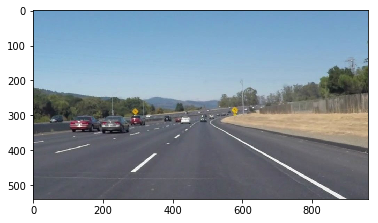

In [6]:
plt.imshow(image)

### Read all images in folder

In [7]:
images = [mpimg.imread('test_images/' + image_name) for image_name in os.listdir("test_images/")]

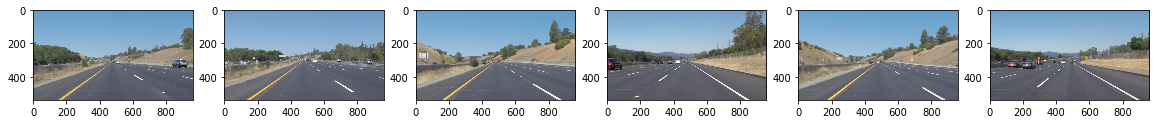

In [8]:
f, axarr = plt.subplots(1, len(images), figsize=(20,20))
for index, image in enumerate(images):
    axarr[index].imshow(image)

plt.show()

## Detecting White Lanes

In [9]:
# set threshold values
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

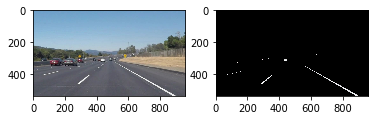

In [10]:
color_thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
        
color_select = np.copy(image)
color_select[color_thresholds] = [0,0,0]

# Display the image   
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image) 
axarr[1].imshow(color_select) 
plt.show()

## Region Masking

In [11]:
ysize = image.shape[0]
xsize = image.shape[1]
line_image = np.copy(image)

# Define the region of interest 
# Note: the origin (x=0, y=0) is in the upper left corner
left_bottom = [0, 539]
right_bottom =[900, 539]
apex = [500, 300]

In [12]:
# Find the polynomials for three lines that fit the region of interest
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the points between the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

In [13]:
# Color in red every white point inside the region
line_image[~color_thresholds & region_thresholds] = [255,0,0]

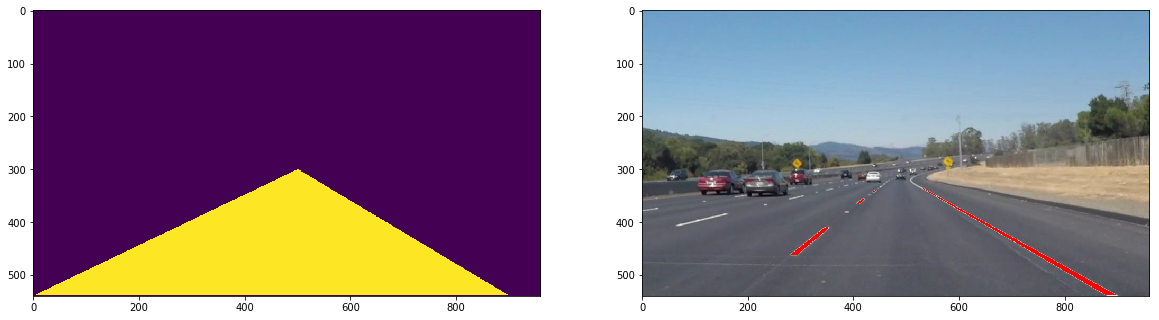

In [14]:
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(region_thresholds) 
axarr[1].imshow(line_image) 
plt.show()

# Finding Lanes of Any Color

## Canny Edge Detection

In [15]:
import cv2

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion

In [16]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: cv2.Canny() also applies a 5x5 Gaussian internally
kernel_size = 9
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

In [17]:
# Define parameters for Canny and run it
low_threshold = 50
high_threshold = 150
masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

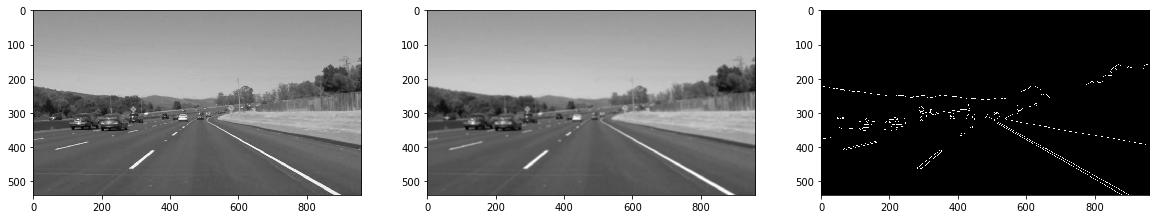

In [18]:
f, axarr = plt.subplots(1,3, figsize=(20,20))
axarr[0].imshow(gray, cmap='gray') 
axarr[1].imshow(blur_gray, cmap='gray') 
axarr[2].imshow(masked_edges, cmap='Greys_r')
plt.show()

## Hough Space 👨‍🚀

In [19]:
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1

# Blank copy for edge drawing
line_image = np.copy(image)*0

In [20]:
# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

In [21]:
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)


In [22]:
# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
# Combine the colored edges image and the gray edges image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)

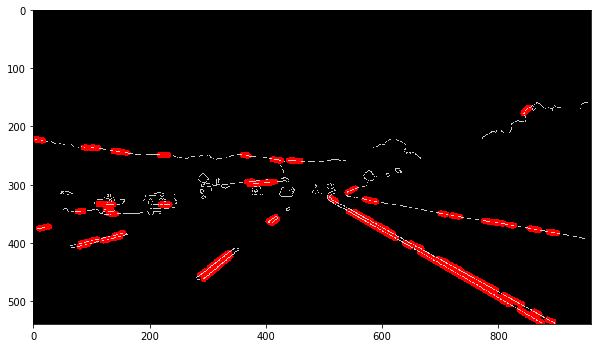

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(combo)

# Putting it all together

In [24]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion

# Gaussian Blur
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Canny Edge Detection
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


# Region of Interest Mask
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

imshape = image.shape
vertices = np.array([[(80,imshape[0]),(475, 275), (imshape[1], 550), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Hough Lines
rho = 1
theta = np.pi/180
threshold = 50
min_line_length = 5
max_line_gap = 5

line_image = np.copy(image)*0

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

## Draw lines
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
color_combo = cv2.addWeighted(image, 0.8, line_image, 1, 0)

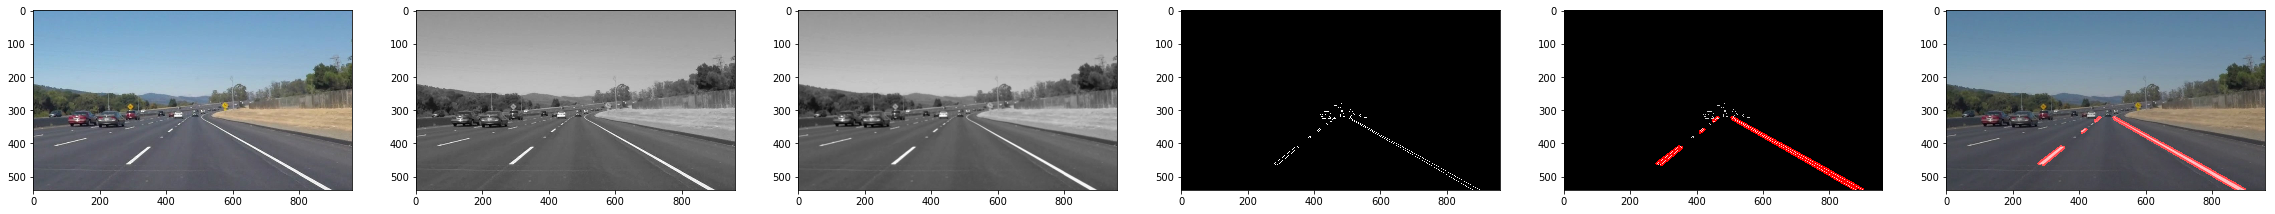

In [25]:
f, axarr = plt.subplots(1,6, figsize=(40,40))
axarr[0].imshow(image)
axarr[1].imshow(gray, cmap='gray') 
axarr[2].imshow(blur_gray, cmap='gray') 
axarr[3].imshow(masked_edges, cmap='Greys_r')
axarr[4].imshow(combo, cmap='Greys_r')
axarr[5].imshow(color_combo)
plt.show()

# Extrapolating lanes

In [26]:
def slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

def slope_sign(x1,y1,x2,y2):
    return np.sign(slope(x1,y1,x2,y2))

In [27]:
negative_slope = []
positive_slope = []

In [28]:
for line in lines:
    for x1,y1,x2,y2 in line:
        if slope_sign(x1,y1,x2,y2) < 0:
            negative_slope.append(line)
        else:
            positive_slope.append(line)

In [29]:
positive_slope_x = []
positive_slope_y = []
negative_slope_x = []
negative_slope_y = []

for line in negative_slope:
    for x1,y1,x2,y2 in line:
        negative_slope_x.append(x1)
        negative_slope_y.append(y1)
        negative_slope_x.append(x2)
        negative_slope_y.append(y2)        
        

for line in positive_slope:
    for x1,y1,x2,y2 in line:
        positive_slope_x.append(x1)
        positive_slope_y.append(y1)
        positive_slope_x.append(x2)
        positive_slope_y.append(y2) 

In [30]:
from scipy import stats

In [31]:
# Using Linear Regression to minimize distance between points
neg_slope, neg_intercept, neg_r_value, neg_p_value, neg_std_err = stats.linregress(negative_slope_x,negative_slope_y)
pos_slope, pos_intercept, pos_r_value, pos_p_value, pos_std_err = stats.linregress(positive_slope_x,positive_slope_y)

In [32]:
min_neg_x = min(negative_slope_x)
min_neg_y = neg_intercept + neg_slope * min_neg_x
max_neg_x = max(negative_slope_x)
max_neg_y = neg_intercept + neg_slope * max_neg_x

min_pos_x = min(positive_slope_x)
min_pos_y = pos_intercept + pos_slope * min_pos_x
max_pos_x = max(positive_slope_x)
max_pos_y = pos_intercept + pos_slope * max_pos_x

negative_line = [min_neg_x, min_neg_y, max_neg_x, max_neg_y]
positive_line = [min_pos_x, min_pos_y, max_pos_x, max_pos_y]

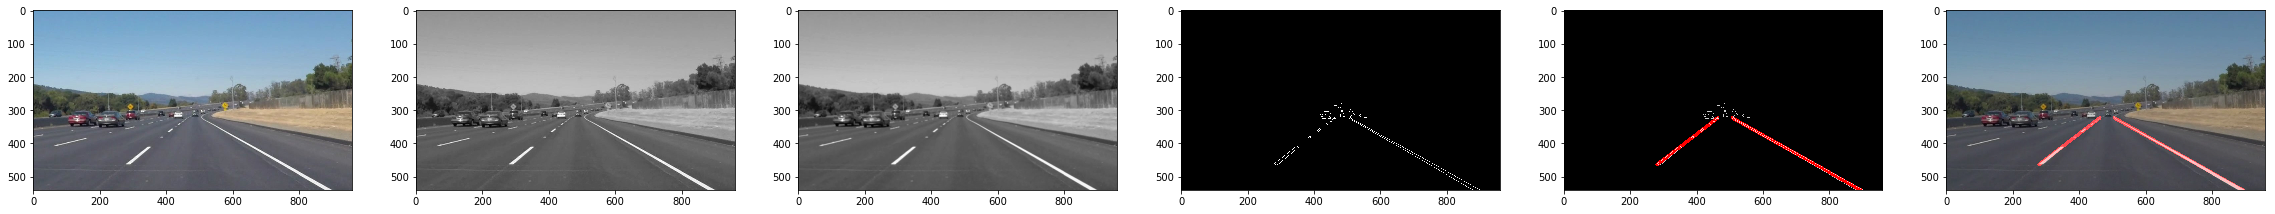

In [33]:
line_image = np.copy(image)*0
cv2.line(line_image,(int(min_neg_x),int(min_neg_y)),(int(max_neg_x),int(max_neg_y)),(255,0,0),10)
cv2.line(line_image,(int(min_pos_x),int(min_pos_y)),(int(max_pos_x),int(max_pos_y)),(255,0,0),10)

color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
color_combo = cv2.addWeighted(image, 0.8, line_image, 1, 0)

f, axarr = plt.subplots(1,6, figsize=(40,40))
axarr[0].imshow(image)
axarr[1].imshow(gray, cmap='gray') 
axarr[2].imshow(blur_gray, cmap='gray') 
axarr[3].imshow(masked_edges, cmap='Greys_r')
axarr[4].imshow(combo, cmap='Greys_r')
axarr[5].imshow(color_combo)
plt.show()

In [34]:
neg_intercept

679.3913423173867